<a href="https://colab.research.google.com/github/Nohyunjin/DeepLearning/blob/main/%EC%9D%8C%EC%84%B1%EC%9D%B8%EC%8B%9D%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! unzip -qq -d ./audio audio.zip

In [19]:
import os
import numpy as np
import random
from time import time
from tqdm import tqdm

import librosa
import librosa.display

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.layers import Bidirectional, BatchNormalization, GRU, Dense, Dropout, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences

In [3]:
MY_SPLIT = 0.8
MY_HIDDEN = 128
MY_DROP = 0.3
MY_BATCH = 128
MY_EPOCH = 100
MY_PATH = './audio'
MY_RATE = 8000

In [25]:
sound, rate = librosa.load('yes-sample.wav')
print("샘플 파일 데이터:", sound)
print("샘플 데이터 개수:", len(sound))
print("샘플링 비율:", rate)

샘플 파일 데이터: [0.00042052 0.00067795 0.0006813  ... 0.00065762 0.00079129 0.00055214]
샘플 데이터 개수: 22050
샘플링 비율: 22050


In [46]:
labels = ["go","happy","seven","stop","yes"]
print(labels)
encoder = LabelEncoder()
encoder.fit(labels)

['go', 'happy', 'seven', 'stop', 'yes']


LabelEncoder()

In [6]:
def read_wave():
    global all_wave, all_label
    all_wave = []
    all_label = []
    for label in tqdm(labels):
        path = MY_PATH + '/' + label
        waves = [f for f in os.listdir(path)]
        for wav in waves :
            file = path + '/' + wav
            samples, rate = librosa.load(file, sr = 16000)
            samples = librosa.resample(samples, orig_sr = rate, target_sr = MY_RATE)

            if len(samples) == MY_RATE :
                all_wave.append(samples)
                all_label.append(label)
    all_label = encoder.transform(all_label)
    all_wave = np.array(all_wave).reshape(-1, MY_RATE, 1)
    print("Resampling 종료")
    print('전체 샘플링 수:', len(all_wave))
    return all_wave, all_label


In [23]:
if os.path.exists('arrays.npy'):
    with open('arrays.npy', 'rb') as f:
        all_wave = np.load(f)
        all_label = np.load(f)
else :
    all_wave, all_label = read_wave()
    with open('arrays.npy', 'wb') as f:
        np.save(f, all_wave)
        np.save(f, all_label)
    print('데이터 파일 완성')
all_wave.shape

(889, 8000, 1)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(all_wave, all_label, train_size = MY_SPLIT, shuffle = True)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(711, 8000, 1) (178, 8000, 1) (711,) (178,)


In [9]:
inputs = Input(shape = (MY_RATE, 1))
x = BatchNormalization()(inputs)

# 첫번째 합성곱
x = Conv1D(filters = 8, kernel_size = 13, padding = 'valid', strides = 1, activation = 'relu')(x)
x = MaxPooling1D(pool_size = 3)(x)
x = Dropout(rate = MY_DROP)(x)

# 두번째 합성곱
x = Conv1D(filters = 16, kernel_size = 11, padding = 'valid', strides = 1, activation = 'relu')(x)
x = MaxPooling1D(pool_size = 3)(x)
x = Dropout(rate = MY_DROP)(x)

# 세번째 합성곱
x = Conv1D(filters = 32, kernel_size = 9, padding = 'valid', strides = 1, activation = 'relu')(x)
x = MaxPooling1D(pool_size = 3)(x)
x = Dropout(rate = MY_DROP)(x)
x = BatchNormalization()(x)

# 첫번째 GRU 층
x = Bidirectional(GRU(units = MY_HIDDEN, return_sequences = True), merge_mode = 'sum')(x)

# 두번째 GRU 층
x = Bidirectional(GRU(units = MY_HIDDEN, return_sequences = True), merge_mode = 'sum')(x)

# 세번째 GRU 층
x = Bidirectional(GRU(units = MY_HIDDEN, return_sequences = False), merge_mode = 'sum')(x)

# 은닉층
x = BatchNormalization()(x)
x = Dense(units = 256, activation = 'relu')(x)

# 출력층
outputs = Dense(units = len(labels), activation = 'softmax')(x)
model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization (BatchN  (None, 8000, 1)          4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424  

In [10]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = 'acc')

In [11]:
if os.path.exists('speech.h5'):
    model.load_weight('speech.h5')
else :
    begin = time()

    hist = model.fit(x = X_train, y = Y_train, epochs = MY_EPOCH, batch_size = MY_BATCH, verbose = 1)
    end = time()
    print(f'총 학습시간 : {(end-begin):.2f}초')
    model.save_weights('speech.h5')

Epoch 1/100
6/6 [==============================] - 23s 166ms/step - loss: 1.7133 - acc: 0.2096
Epoch 2/100
6/6 [==============================] - 1s 153ms/step - loss: 1.7102 - acc: 0.2068
Epoch 3/100
6/6 [==============================] - 1s 155ms/step - loss: 1.6358 - acc: 0.2405
Epoch 4/100
6/6 [==============================] - 1s 155ms/step - loss: 1.6210 - acc: 0.2363
Epoch 5/100
6/6 [==============================] - 1s 154ms/step - loss: 1.5932 - acc: 0.2546
Epoch 6/100
6/6 [==============================] - 1s 154ms/step - loss: 1.5718 - acc: 0.2433
Epoch 7/100
6/6 [==============================] - 1s 153ms/step - loss: 1.5613 - acc: 0.2714
Epoch 8/100
6/6 [==============================] - 1s 156ms/step - loss: 1.5654 - acc: 0.2827
Epoch 9/100
6/6 [==============================] - 1s 156ms/step - loss: 1.5529 - acc: 0.2813
Epoch 10/100
6/6 [==============================] - 1s 154ms/step - loss: 1.5169 - acc: 0.3094
Epoch 11/100
6/6 [==============================] - 1s 152

In [13]:
scores = model.evaluate(x = X_test, y = Y_test, verbose = 1)
print(f'평가 데이터의 정확도: {scores[1]:.2f}')

6/6 [==============================] - 0s 41ms/step - loss: 0.9100 - acc: 0.7865
평가 데이터의 정확도: 0.79


In [47]:
def audio_to_text(audio):
    pred = model.predict(audio.reshape(1, MY_RATE, 1))
    index = np.argmax(pred[0])
    return labels[index]

In [79]:
rand_dir = random.choice(os.listdir(MY_PATH))
print(rand_dir)

rand_path = random.choice(os.listdir(MY_PATH + '/' + rand_dir))
picked = os.path.join(MY_PATH, rand_dir, rand_path)
picked_label = rand_dir
print(picked)

import IPython
IPython.display.Audio(picked)

go
./audio/go/da584bc0_nohash_2.wav


In [80]:
y, sr = librosa.load(picked, sr = 16000)
sample = librosa.resample(y, orig_sr = sr, target_sr = MY_RATE)
sample = pad_sequences(np.array(sample).reshape(1, -1), maxlen = MY_RATE, padding = 'post', dtype = float)

In [81]:
sample = np.array(sample).reshape(-1, MY_RATE, 1)
print(audio_to_text(sample))

go


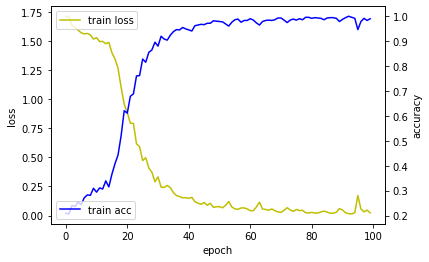

In [69]:
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'b', label = 'train acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc = 'lower left')
plt.show()